# Walmart Sales

We use the data from the Walmart Sales Forecasting competition. We want to predict sales for one week ahead.

In [1]:
import pandas as pd

from darts import TimeSeries
from utils import TimeseriesExperiment, Dataset


DATASET_NAME = "walmart-sales"
ACCELERATOR = "cpu"
DATASET_FOLDER = "data/walmart-sales"
USE_PRETRAINED_MODEL = False

## Load the data

In [2]:
STORE_ID = 1

# Load data
df_train = pd.read_csv(f"{DATASET_FOLDER}/train.csv")
df_features = pd.read_csv(f"{DATASET_FOLDER}/features.csv")
df_stores = pd.read_csv(f"{DATASET_FOLDER}/stores.csv")

def get_dataframe_for_store_id(store_id):
    # Get data from one store
    df = df_train[df_train["Store"] == store_id]
    df = df[df["Dept"] == store_id]

    # Drop redundant columns
    df = df.drop(["Store", "Dept", "IsHoliday"], axis=1)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").resample("W").mean()


    df_features2 = df_features[df_features["Store"] == store_id]
    df_features2 = df_features2.drop(
        ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"], axis=1
    )
    df_features2["Date"] = pd.to_datetime(df_features2["Date"])
    df_features2 = df_features2.set_index("Date").resample("W").mean()

    df = df.join(df_features2, how="left")

    return df

df = get_dataframe_for_store_id(STORE_ID)
df.head()

,Weekly_Sales,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
Date,,,,,,,
2010-02-07,24924.50,1.0,42.31,2.572,211.096358,8.106,0.0
2010-02-14,46039.49,1.0,38.51,2.548,211.242170,8.106,1.0
2010-02-21,41595.55,1.0,39.93,2.514,211.289143,8.106,0.0
2010-02-28,19403.54,1.0,46.63,2.561,211.319643,8.106,0.0
2010-03-07,21827.90,1.0,46.50,2.625,211.350143,8.106,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train size: 9 Test size: 9
<TimeSeries (DataArray) (Date: 143, component: 1, sample: 1)> Size: 1kB
array([[[24924.5 ]],

       [[46039.49]],

       [[41595.55]],

       [[19403.54]],

       [[21827.9 ]],

       [[21043.39]],

       [[22136.64]],

       [[26229.21]],

       [[57258.43]],

       [[42960.91]],

...

       [[16286.4 ]],

       [[16680.24]],

       [[18322.37]],

       [[19616.22]],

       [[19251.5 ]],

       [[18947.81]],

       [[21904.47]],

       [[22764.01]],

       [[24185.27]],

       [[27390.81]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1kB 2010-02-07 2010-02-14 ... 2012-10-28
  * component  (component) object 8B 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (Date: 115, component: 1, sample: 1)> Size: 920B
array([[[24924.5 ]],

       [[46039.49]],

       [[41595.55]],

       [[19403.54]],

       [[21827.9 ]],

       [[21043.39]],


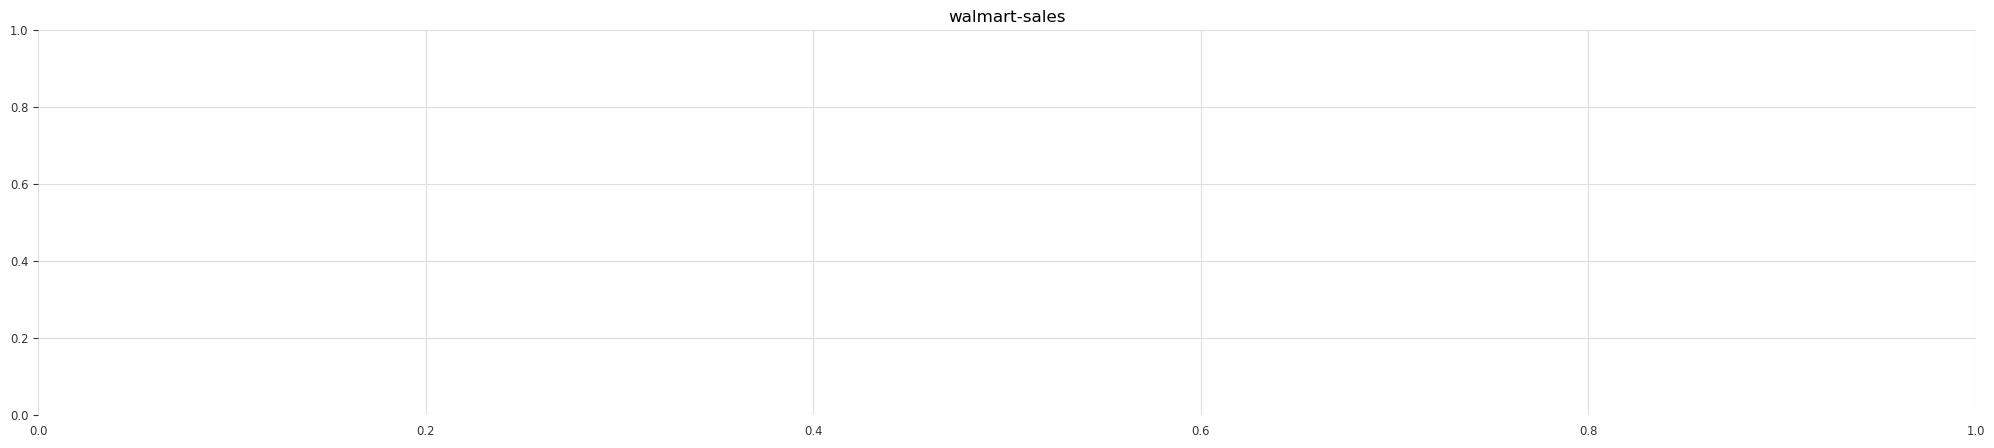

In [3]:
def get_timeseries_from_dataframe(df_):
    df_target = df_["Weekly_Sales"]
    df_past = df_[
        ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
    ]

    df_future = df_["IsHoliday"]

    target = TimeSeries.from_series(df_target, freq="W", fill_missing_dates=True)
    past_covariates = TimeSeries.from_dataframe(df_past, freq="W", fill_missing_dates=True)
    future_covariates = TimeSeries.from_series(df_future, freq="W", fill_missing_dates=True)

    return target, past_covariates, future_covariates

target, past_covariates, future_covariates = [], [], []

for i in range(1, 10):
    df2 = get_dataframe_for_store_id(i)
    target_, past_covariates_, future_covariates_ = get_timeseries_from_dataframe(df2)
    target.append(target_)
    past_covariates.append(past_covariates_)
    future_covariates.append(future_covariates_)



dataset = Dataset(
    target,
    "walmart-sales",
    past_covariates=past_covariates,
    future_covariates=future_covariates,
)
dataset.plot_train_test()

# print(dataset.train.time_index[-1])
# print(dataset.test.time_index[0])

## Models

### Baseline

In [8]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)

experiment1 = TimeseriesExperiment(
    model, dataset, retrain=True, use_pretrained_model=USE_PRETRAINED_MODEL
)

experiment1.run()

ValueError: Train `series` must be a single `TimeSeries`.


ValueError: Train `series` must be a single `TimeSeries`.

In [6]:
# arima
from darts.models import ARIMA

model = ARIMA()

experiment2 = TimeseriesExperiment(
    model,
    dataset,
    {"p": [1, 3, 5, 7, 9], "d": [1, 2, 3], "q": [0, 1]},
    retrain=True,
    use_pretrained_model=USE_PRETRAINED_MODEL,
)

experiment2.run()

Searching for best parameters {'p': [1, 3, 5, 7, 9], 'd': [1, 2, 3], 'q': [0, 1]}


/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

TypeError: float() argument must be a string or a real number, not 'list'

In [7]:
from darts.models import XGBModel

model = XGBModel(
    lags=1,
    lags_past_covariates=1,
)

experiment3 = TimeseriesExperiment(
    model,
    dataset,
    {
        "lags": [3, 7, 14],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5],
        "n_estimators": [10, 25, 50],
        "output_chunk_length": [1, 3],
    },
    use_pretrained_model=USE_PRETRAINED_MODEL,
    retrain=False,
)

experiment3.run()

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Searching for best parameters {'lags': [3, 7, 14], 'lags_past_covariates': [1, 2], 'max_depth': [3, 5], 'n_estimators': [10, 25, 50], 'output_chunk_length': [1, 3]}


IndexError: list index out of range

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


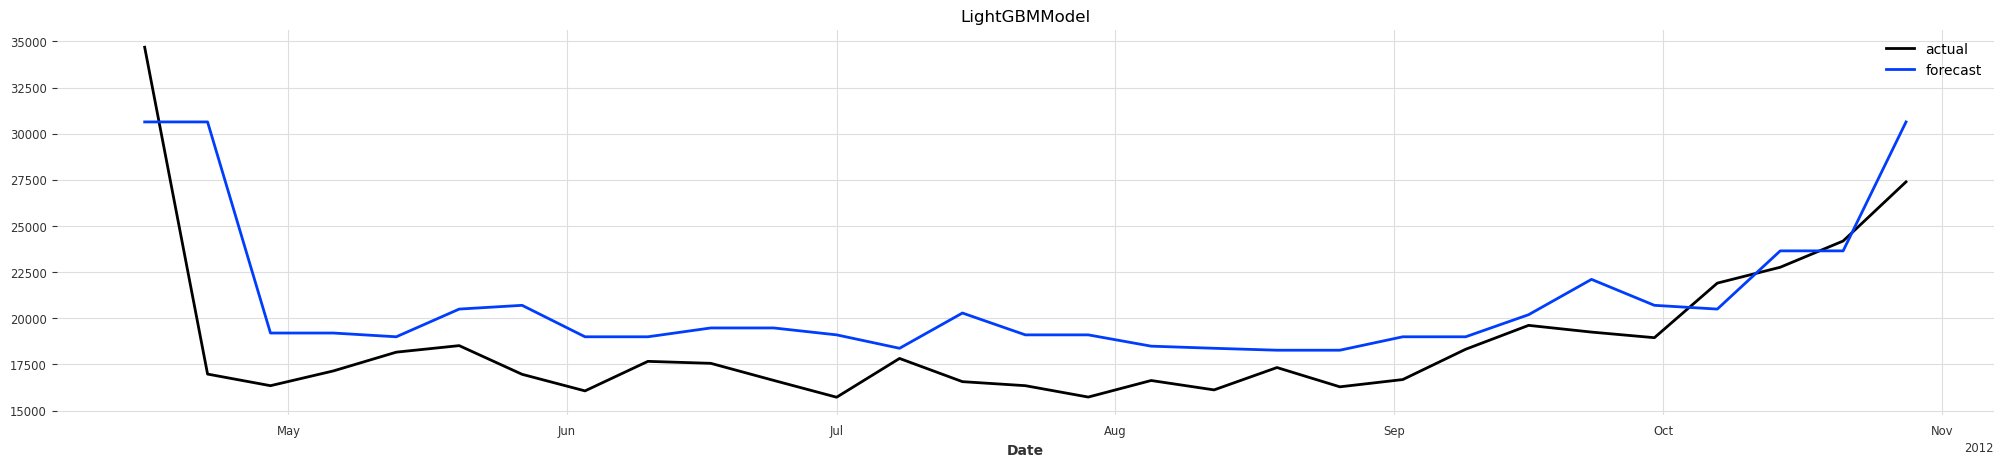

{'mape': 14.127705817909337,
 'mse': 11892225.511994362,
 'rmse': 3448.5106222823733,
 'mae': 2525.7630194330527,
 'model': 'LightGBMModel',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1716819289.521527,
 'parameters': OrderedDict([('lags', 1),
              ('lags_past_covariates', 1),
              ('lags_future_covariates', None),
              ('output_chunk_length', 3),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('categorical_past_covariates', None),
              ('categorical_future_covariates', None),
              ('categorical_static_covariates', None),
              ('max_depth', 5),
              ('n_estimators', 10)])}

In [ ]:
from darts.models import LightGBMModel

model_lgbm = LightGBMModel(
    lags=1,
    lags_past_covariates=1,
)

experiment4 = TimeseriesExperiment(
    model_lgbm,
    dataset,
    {
        "lags": [1, 4],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5, 7],
        "n_estimators": [10, 25, 50],
        "output_chunk_length": [1, 3],
    },
    use_pretrained_model=USE_PRETRAINED_MODEL,
)

experiment4.run()

10:32:37 - cmdstanpy - INFO - Chain [1] start processing
10:32:37 - cmdstanpy - INFO - Chain [1] done processing
10:32:37 - cmdstanpy - INFO - Chain [1] start processing
10:32:37 - cmdstanpy - INFO - Chain [1] done processing
10:32:37 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1] done processing
10:32:38 - cmdstanpy - INFO - Chain [1] start processing
10:32:38 - cmdstanpy - INFO - Chain [1]

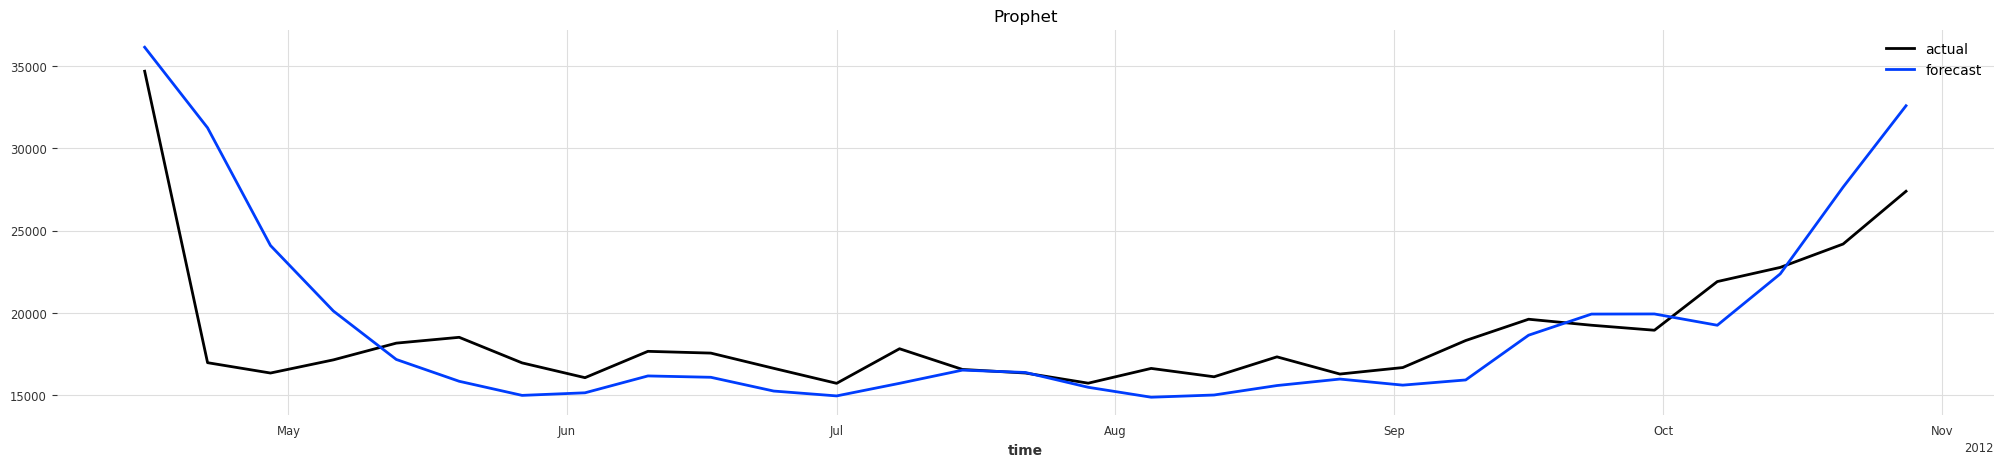

{'mape': 11.850155580008144,
 'mse': 12470350.394666571,
 'rmse': 3531.338329113563,
 'mae': 2180.9274256388712,
 'model': 'Prophet',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1717835559.481112,
 'parameters': OrderedDict([('add_seasonalities', None),
              ('country_holidays', None),
              ('suppress_stdout_stderror', True),
              ('add_encoders', None),
              ('cap', None),
              ('floor', None)])}

In [ ]:
from darts.models import Prophet

model_prophet = Prophet()

params_prophet = {
    'add_seasonalities': [{}, {
        'name':"yearly_seasonality",
        'seasonal_periods': 52,
        'fourier_order': 5
    }]
}

experiment_prophet = TimeseriesExperiment(
    model_prophet, dataset, params_prophet, use_pretrained_model=USE_PRETRAINED_MODEL, retrain=True
)

experiment_prophet.run()

In [9]:
from darts.models import TFTModel

model_tft = TFTModel(input_chunk_length=16, output_chunk_length=1)

params_fft = {
    "input_chunk_length": [4],
    "output_chunk_length": [1],
    "pl_trainer_kwargs": [{"accelerator": ACCELERATOR}],
}

experiment_tft = TimeseriesExperiment(
    model_tft,
    dataset,
    params_fft,
    use_pretrained_model=USE_PRETRAINED_MODEL
)

experiment_tft.run()

In [ ]:
from darts.models.forecasting.rnn_model import RNNModel

lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    input_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"accelerator": ACCELERATOR},
)

experiment_lstm = TimeseriesExperiment(lstm_model, dataset, retrain=True, use_pretrained_model=USE_PRETRAINED_MODEL)

experiment_lstm.run()

## Results

In [ ]:
from utils import read_results

df = read_results()
df = df[df["dataset"] == DATASET_NAME]

# print MSE for each model, print millions: 5M, 10M, 15M, etc

for model_name in df["model"].unique():
    model_df = df[df["model"] == model_name]
    mse = model_df["mse"].mean()
    print(f"{model_name}: {mse/1e6:.2f}M")

LightGBMModel: 11.89M
XGBModel: 5.82M
ARIMA: 35.58M
NaiveSeasonal: 30.50M
TFTModel: 26.97M
Prophet: 12.47M
RNNModel: 9.72M


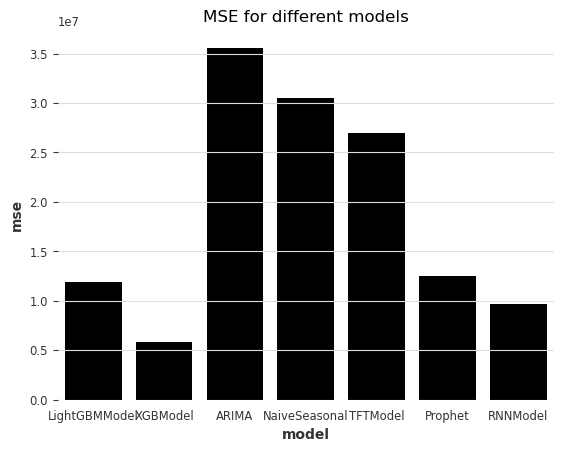

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("MSE for different models")
sns.barplot(data=df, x="model", y="mse")

plt.savefig(f"results/{DATASET_NAME}/mse.png")

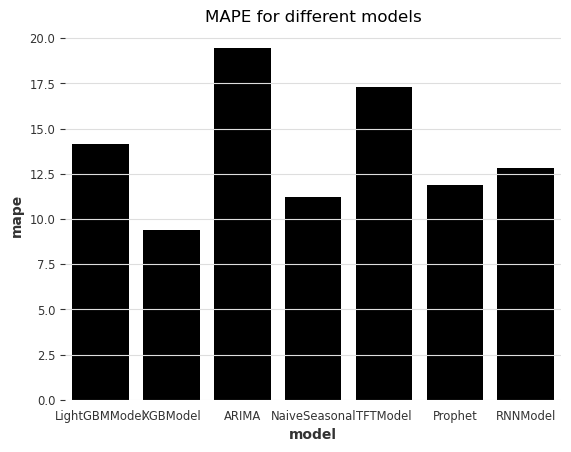

In [ ]:
plt.title("MAPE for different models")
sns.barplot(data=df, x="model", y="mape")

plt.savefig(f"results/{DATASET_NAME}/mape.png")